In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


# -----------------------------------------------------------------
# Step 1: Data Preparation
# -----------------------------------------------------------------

In [ ]:
# Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Total spend
    'TransactionID': 'count'      # Total number of transactions
}).rename(columns={
    'TotalValue': 'TotalSpend',
    'TransactionID': 'TransactionCount'
}).reset_index()

In [ ]:
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)


In [ ]:
# Drop irrelevant columns and encode categorical data
customer_data_encoded = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [ ]:
features = ['TotalSpend', 'TransactionCount'] + [col for col in customer_data_encoded.columns if 'Region_' in col]


In [ ]:
# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_data_encoded[features])


# -----------------------------------------------------------------
# Step 2: Clustering
# -----------------------------------------------------------------

In [ ]:
# Find the optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(normalized_features, kmeans.labels_))


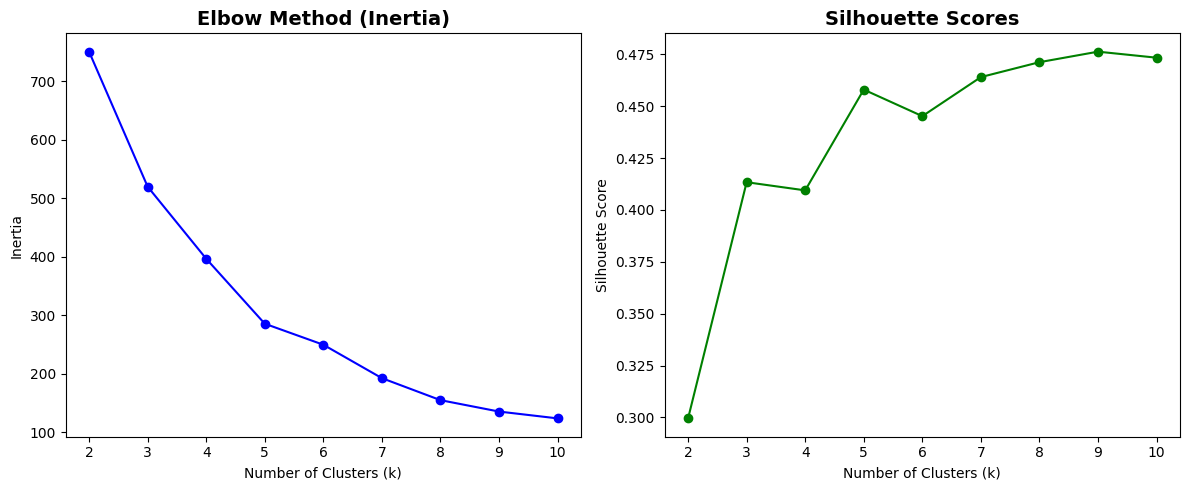

In [ ]:
# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method (Inertia)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='green')
plt.title('Silhouette Scores', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
# Choose the optimal number of clusters based on the plots (e.g., k=3)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_features)

# Add cluster labels to the customer data
customer_data['Cluster'] = cluster_labels

# -----------------------------------------------------------------
# Step 3: Clustering Metrics
# -----------------------------------------------------------------

In [ ]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(normalized_features, cluster_labels)
silhouette_avg = silhouette_score(normalized_features, cluster_labels)

print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")

Davies-Bouldin Index: 0.85
Silhouette Score: 0.46


# -----------------------------------------------------------------
# Step 4: Visualization
# -----------------------------------------------------------------

In [ ]:
# Reduce dimensionality for visualization (PCA to 2D)
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(normalized_features)

In [ ]:
# Add PCA components and cluster labels to the data
customer_data['PCA1'] = reduced_features[:, 0]
customer_data['PCA2'] = reduced_features[:, 1]

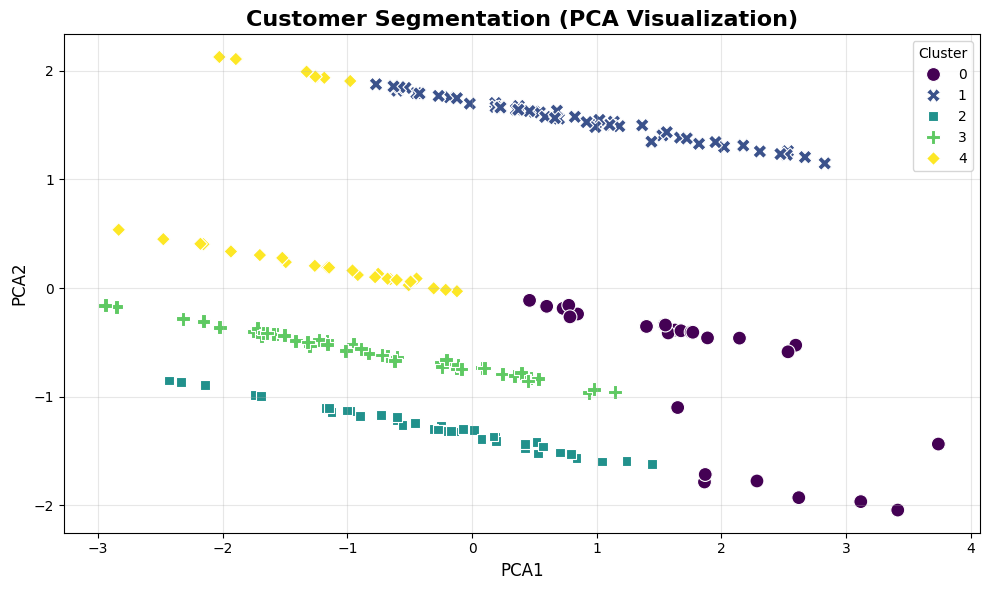

In [ ]:

# Visualize clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data,
    palette='viridis', style='Cluster', s=100
)
plt.title('Customer Segmentation (PCA Visualization)', fontsize=16, fontweight='bold')
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# Step 5: Save Results
# -----------------------------------------------------------------

In [ ]:
# Save the cluster assignments to a CSV
customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)


In [ ]:
# Summary of each cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalSpend': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
          TotalSpend           TransactionCount        CustomerCount
                mean    median             mean median         count
Cluster                                                             
0        5824.304615  5690.760         8.153846    8.0            26
1        4178.601961  3850.940         5.627451    5.0            51
2        2855.817250  2898.735         4.650000    5.0            40
3        3119.412292  3071.455         4.479167    5.0            48
4        1756.870286  1862.740         2.857143    3.0            35
